In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob
import seaborn as sns
from wordcloud import WordCloud
import glob

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

# spacy
import spacy
from nltk.corpus import stopwords

# viz
import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
# using these parts of speech result in the best results
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ". join(new_text)
        texts_out.append(final)
    return texts_out

In [3]:
trans_reviews = pd.read_csv('olist_order_reviews_dataset_with_translation.csv',error_bad_lines=False)

/Users/davidlam/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Only care about records that have reviews
trans_reviews = trans_reviews[trans_reviews['review_comment_message_english'].notna()]
trans_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_title_english,review_comment_message_english
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,NaN,I received well before the stipulated deadline.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,NaN,Congratulations LANNISTER stores I loved to bu...
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,I recommend,efficient device. on the site the mark of the ...
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,NaN,"But a little, catching ... for the value is go..."
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,Super recommend,"Reliable seller, product ok and delivery befor..."
...,...,...,...,...,...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,NaN,para este produto recebi de acordo com a compr...,2017-11-29 00:00:00,2017-11-30 15:52:51,NaN,For this product I received according to the p...
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,NaN,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23,NaN,Delivered within the deadline. The product has...
99215,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,NaN,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06,NaN,"The product was not sent with NF, there is no ..."
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,NaN,"Excellent backpack, super fast delivery. Super..."


In [5]:
# remove stop words
stop = stopwords.words('english')
trans_reviews['review_comment_message_english'] = trans_reviews['review_comment_message_english'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [8]:
# lemmatization
trans_reviews['review_comment_message_english'] = trans_reviews['review_comment_message_english'].astype(str)
trans_reviews['processed_reviews'] = lemmatization(trans_reviews['review_comment_message_english'])

In [9]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return final

trans_reviews['processed_reviews'] = gen_words(trans_reviews['processed_reviews'])
trans_reviews['processed_reviews']

3                     [receive, well, stipulate, deadline]
4        [congratulation, store, love, buy, internet, s...
9        [efficient, device, site, mark, device, print,...
12                            [little, catch, value, good]
15         [reliable, seller, product, ok, delivery, time]
                               ...                        
99205           [product, receive, accord, purchase, hold]
99208    [deliver, deadline, product, reach, perfect, c...
99215    [product, send, sale, be, sure, be, wait, send...
99221    [excellent, backpack, super, fast, delivery, s...
99223    [product, arrive, already, return, defective, ...
Name: processed_reviews, Length: 40950, dtype: object

In [10]:
# bigrams and trigrams, so we can recognise a collection of words
bigram_phrases = gensim.models.Phrases(trans_reviews['processed_reviews'], min_count=5,threshold=50)
trigram_phrases = gensim.models.Phrases(bigram_phrases[trans_reviews['processed_reviews']],threshold=50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return ([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(trans_reviews['processed_reviews'])
data_bigrams_trigrams = make_trigrams(data_bigrams)

In [11]:
# TF-IDF removal, remove low value words
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [12]:
# train the topic model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha="auto")

In [13]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,id2word,mds="mmds",R=20)
vis

/Users/davidlam/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.403080  0.260732       1        1  27.120669
2      0.120327  0.425646       2        1  12.221030
1     -0.336013 -0.252488       3        1  10.177530
7     -0.248148  0.419076       4        1   9.291822
0      0.200581 -0.425233       5        1   8.847337
4     -0.173549  0.155999       6        1   8.842357
9     -0.108903 -0.416678       7        1   7.936660
5     -0.466783  0.016111       8        1   6.351213
8      0.169737 -0.068295       9        1   5.727770
3      0.439671 -0.114871      10        1   3.483613, topic_info=           Term          Freq         Total Category  logprob  loglift
29      product  19936.000000  19936.000000  Default  20.0000  20.0000
1       receive   6464.000000   6464.000000  Default  19.0000  19.0000
27     delivery   6397.000000   6397.000000  Default  18.0000  18.0000
66         come   4774.000000   4774.000000  Default  17.0000  17.0000
4           buy   4776.000000   4776.000000  Default  16.0000  16.0000
...         ...           ...           ...      ...      ...      ...
879       light    101.557740    102.491361  Topic10  -4.4167   3.3479
938      before     98.810881     99.744597  Topic10  -4.4441   3.3477
1218   daughter     94.637190     95.570827  Topic10  -4.4873   3.3473
660    estimate     86.642885     87.576649  Topic10  -4.5755   3.3464
663   attentive     86.161235     87.094871  Topic10  -4.5811   3.3463

[220 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
155       4  0.997663     accord
842       6  0.993004  afternoon
152       7  0.998802        all
42        3  0.999093    already
33       10  0.998637     always
...     ...       ...        ...
328       5  0.995223  wonderful
168       5  0.999256       work
571       8  0.995323      worth
705       2  0.998787      wrong
65        7  0.999223        yet

[200 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 2, 8, 1, 5, 10, 6, 9, 4])

In [14]:
# get most dominant class for each record
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=trans_reviews['review_comment_message_english']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    review_score = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=trans_reviews['review_comment_message_english'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.2772,"product, good, deadline, deliver, arrive, reco...",NaN
1,1,6.0,0.2424,"product, good, deadline, deliver, arrive, reco...",NaN
2,2,8.0,0.3161,"time, site, package, seller, correct, ok, pack...",NaN
3,3,6.0,0.2772,"product, good, deadline, deliver, arrive, reco...",I received well stipulated deadline.
4,4,6.0,0.2587,"product, good, deadline, deliver, arrive, reco...",Congratulations LANNISTER stores I loved buy i...
5,5,6.0,0.2330,"product, good, deadline, deliver, arrive, reco...",NaN
6,6,6.0,0.2704,"product, good, deadline, deliver, arrive, reco...",NaN
7,7,6.0,0.2600,"product, good, deadline, deliver, arrive, reco...",NaN
8,8,6.0,0.2503,"product, good, deadline, deliver, arrive, reco...",NaN
9,9,1.0,0.2909,"purchase, store, make, already, give, far, lon...",efficient device. site mark device printed 3de...


In [17]:
trans_reviews_with_class = pd.merge(trans_reviews, df_dominant_topic, left_on='review_comment_message_english', right_on='Text', how='left')

In [19]:
poor_trans_reviews_with_class = trans_reviews_with_class[(trans_reviews_with_class['review_score'] == 1) & (trans_reviews_with_class['review_score'] == 1)]

In [44]:
poor_trans_reviews_with_class

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_title_english,review_comment_message_english,processed_reviews,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
6,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,My product has not arrived,Terrible,[terrible],19,6.0,0.3589,"product, good, deadline, deliver, arrive, reco...",Terrible
7,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,My product has not arrived,Terrible,[terrible],22918,6.0,0.2282,"product, good, deadline, deliver, arrive, reco...",Terrible
8,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,My product has not arrived,Terrible,[terrible],49365,NaN,NaN,NaN,Terrible
9,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,My product has not arrived,Terrible,[terrible],57967,NaN,NaN,NaN,Terrible
10,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,My product has not arrived,Terrible,[terrible],60162,NaN,NaN,NaN,Terrible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756581,9bab7509047d0b236205e330172b384d,e78cde66f03731202b0f5e082b0b0cff,1,NaN,Gostaria de saber porque meu produto ainda não...,2018-03-29 00:00:00,2018-03-29 22:21:55,NaN,I would like know product yet arrived residenc...,"[like, know, product, yet, arrive, residence, ...",99094,NaN,NaN,NaN,I would like know product yet arrived residenc...
757122,9ed2a6bc2282fd2b0105055631afa57f,a7db1b7bfec5e83a8fd33625e99f0d15,1,NaN,Ate hoje dia 21/10/2017 o pedido não foi entre...,2017-10-21 00:00:00,2017-10-21 18:51:37,NaN,"Until today 21/10/2017 request delivered, Amer...","[today, request, deliver, american, own, happe...",99141,NaN,NaN,NaN,"Until today 21/10/2017 request delivered, Amer..."
757129,2fc8295a24978092328d3a329d22940e,e809c167a9cfd31aee1293abe8995065,1,NaN,Eu recebi o seguinte email e preciso saber com...,2018-02-09 00:00:00,2018-02-13 13:03:24,NaN,I received following email I need know recover...,"[receive, follow, email, need, know, recover, ...",99155,NaN,NaN,NaN,I received following email I need know recover...
757135,3450ec3bbabeb09a08b00fc72da87a30,c46f950813dd2dd9bab4188dceb83175,1,NaN,Boa tarde. \r\nNão recebo todos os produtos fa...,2017-12-08 00:00:00,2017-12-08 19:07:00,NaN,Good afternoon. I get products missing comfort...,"[good, afternoon, get, product, miss, comfort,...",99169,NaN,NaN,NaN,Good afternoon. I get products missing comfort...


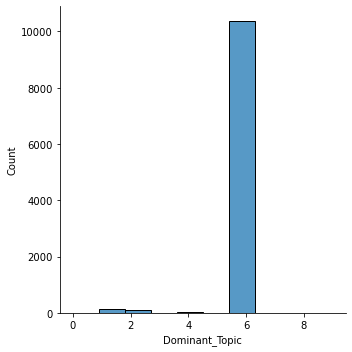

In [21]:
sns.displot(poor_trans_reviews_with_class['Dominant_Topic'], kde=False,bins=10)

In [23]:
class_six = poor_trans_reviews_with_class[poor_trans_reviews_with_class['Dominant_Topic'] == 6.0]

In [43]:
class_six

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_title_english,review_comment_message_english,processed_reviews,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
6,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,My product has not arrived,Terrible,[terrible],19,6.0,0.3589,"product, good, deadline, deliver, arrive, reco...",Terrible
7,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,My product has not arrived,Terrible,[terrible],22918,6.0,0.2282,"product, good, deadline, deliver, arrive, reco...",Terrible
19,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1,NaN,Sempre compro pela Internet e a entrega ocorre...,2018-04-08 00:00:00,2018-04-09 12:22:39,NaN,I always buy Internet delivery occurs combined...,"[always, buy, internet, delivery, occur, combi...",32,6.0,0.2921,"product, good, deadline, deliver, arrive, reco...",I always buy Internet delivery occurs combined...
197,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,NaN,Nada de chegar o meu pedido.,2017-04-21 00:00:00,2017-04-23 05:37:03,NaN,Nothing get request.,"[get, request]",39,6.0,0.2600,"product, good, deadline, deliver, arrive, reco...",Nothing get request.
202,e233e51d11511bf30e568c76360ace52,548df2c6e5f089574614894bca78acf5,1,NaN,recebi somente 1 controle Midea Split ESTILO.\...,2018-01-28 00:00:00,2018-02-04 11:06:15,NaN,I received 1 Midea Split style control. Missed...,"[receive, style, control, miss, remote, contro...",51,6.0,0.2676,"product, good, deadline, deliver, arrive, reco...",I received 1 Midea Split style control. Missed...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755833,0e14328c3b11b13f12f258be554fa682,709757992cd81f180be8b5555ea266f5,1,NaN,nao recebi o produto,2018-08-19 00:00:00,2018-08-20 12:35:39,NaN,I receive product,"[receive, product]",38508,6.0,0.2956,"product, good, deadline, deliver, arrive, reco...",I receive product
755834,0e14328c3b11b13f12f258be554fa682,709757992cd81f180be8b5555ea266f5,1,NaN,nao recebi o produto,2018-08-19 00:00:00,2018-08-20 12:35:39,NaN,I receive product,"[receive, product]",40835,6.0,0.2817,"product, good, deadline, deliver, arrive, reco...",I receive product
756561,fade356e7332606aa22776d8d553cdce,837b75362f8a7c08c85182dfd16cb72d,1,NaN,Ainda nao recevi o produto.,2018-08-12 00:00:00,2018-08-12 13:51:31,NaN,I received product.,"[receive, product]",14635,6.0,0.3589,"product, good, deadline, deliver, arrive, reco...",I received product.
756562,fade356e7332606aa22776d8d553cdce,837b75362f8a7c08c85182dfd16cb72d,1,NaN,Ainda nao recevi o produto.,2018-08-12 00:00:00,2018-08-12 13:51:31,NaN,I received product.,"[receive, product]",21218,6.0,0.2817,"product, good, deadline, deliver, arrive, reco...",I received product.


In [24]:
class_six.to_csv('class_six.csv', index=False)

In [ ]:
## Creation of word cloud

In [33]:
trans_reviews = pd.read_csv('olist_order_reviews_dataset_with_translation.csv',error_bad_lines=False)
trans_reviews = trans_reviews[trans_reviews['review_comment_message_english'].notna()]

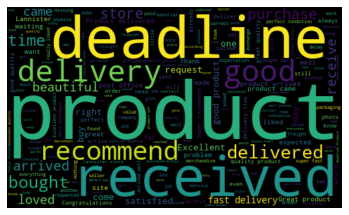

In [34]:
allWords = ' '.join(trans_reviews['review_comment_message_english'])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
## Creation of word cloud for class six

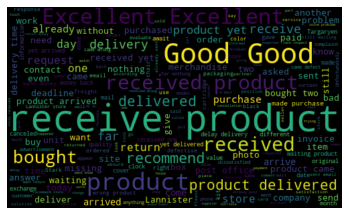

In [42]:
allWords = ' '.join(class_six['review_comment_message_english'])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [38]:
## review score distribution

In [39]:
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

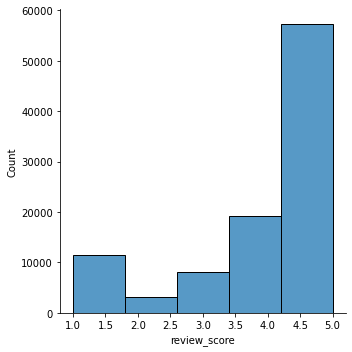

In [40]:
sns.displot(reviews['review_score'], kde=False,bins=5)